#DIFFO MBOUDJIHO Annette Dariose

## Bayesian workflow

##Task 18

Modify the model so that it fits better.

Hint: apply a transformation to input data, e.g. a polynomial.

For this model,

plot prior predictive distribution,

perform inference,

plot posterior predictive distribution.

###Solution_Task_18

In [ ]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

import jax
import jax.numpy as jnp
from jax import random

import arviz as az
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!wget -O Howell1.csv https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv

df = pd.read_csv('Howell1.csv', sep=";")
df.head()

--2024-04-06 20:58:56--  https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12205 (12K) [text/plain]
Saving to: ‘Howell1.csv’

Howell1.csv         100%[===================>]  11.92K  --.-KB/s    in 0.002s  

2024-04-06 20:58:57 (5.51 MB/s) - ‘Howell1.csv’ saved [12205/12205]



height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [ ]:
# observed data
weight = df.weight.values
height = df.height.values

In [ ]:
# data to make predictions for
weight_pred = jnp.array([45, 40, 65, 31, 53])

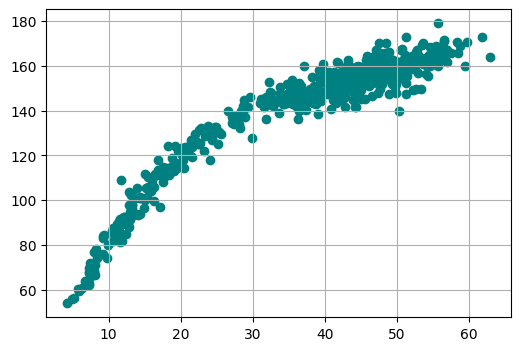

In [ ]:
# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x='weight', y='height', data=df, color='teal')
plt.grid(0.3)

In [ ]:
# Modified model with polynomial transformation
def model_poly(weight=None, height=None):
    # Priors
    b0 = numpyro.sample('b0', dist.Normal(100, 10))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))  # Additional parameter for polynomial transformation
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))
    # Polynomial transformation
    mu = b0 + b1 * weight + b2 * weight**2  # Second-degree polynomial transformation
    # Likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

In [ ]:
# Prior predictive with the updated model
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model_poly, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)


In [ ]:
prior_predictions.keys()

dict_keys(['b0', 'b1', 'b2', 'obs', 'sigma'])

In [ ]:
pred_obs = prior_predictions['obs']
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

In [ ]:
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean, color='teal')
    ax.plot(weight, ht, 'o', color='orangered')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True, color='teal')
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

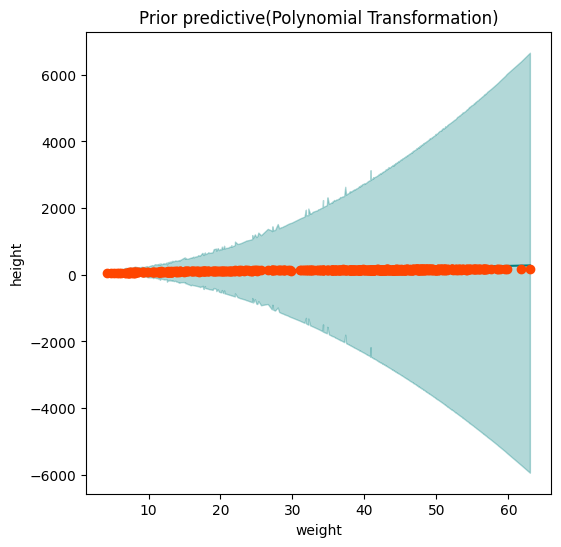

In [ ]:
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive(Polynomial Transformation)")

In [ ]:
# Run inference with the modified model
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
# Run NUTS
kernel = NUTS(model_poly)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_poly = mcmc.get_samples()

<ipython-input-13-d30defd7c7b7>:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     46.77      1.17     46.74     44.85     48.69   2290.93      1.00
        b1      4.14      0.08      4.14      4.00      4.28   2251.36      1.00
        b2     -0.04      0.00     -0.04     -0.04     -0.04   2411.68      1.00
     sigma      5.78      0.18      5.77      5.48      6.07   2503.68      1.00

Number of divergences: 0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     46.77      1.17     46.74     44.85     48.69   2290.93      1.00
        b1      4.14      0.08      4.14      4.00      4.28   2251.36      1.00
        b2     -0.04      0.00     -0.04     -0.04     -0.04   2411.68      1.00
     sigma      5.78      0.18      5.77      5.48      6.07   2503.68      1.00

Number of divergences: 0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


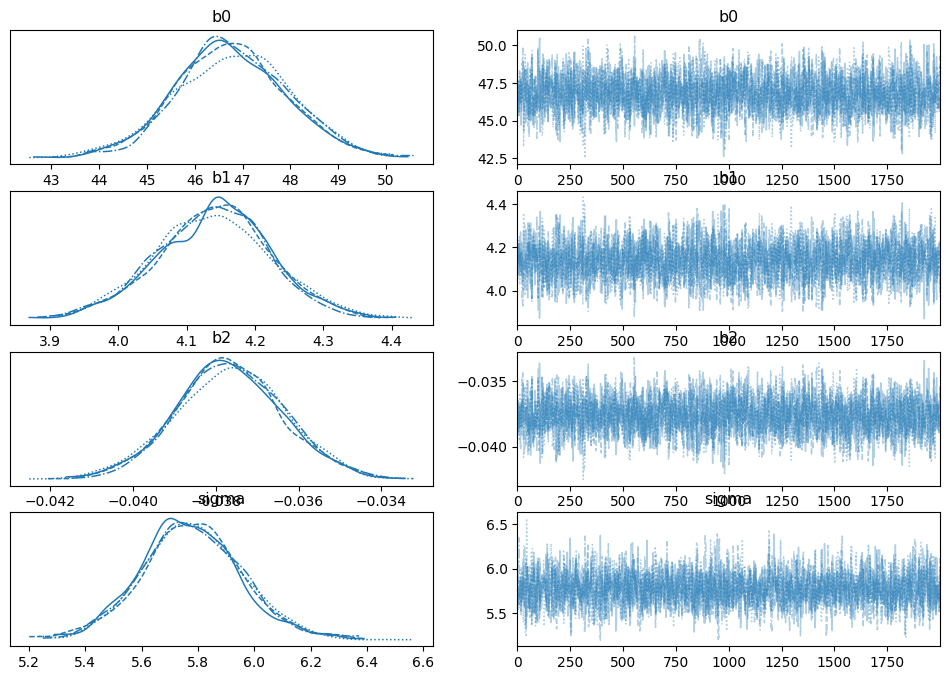

In [ ]:
# Check convergence
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

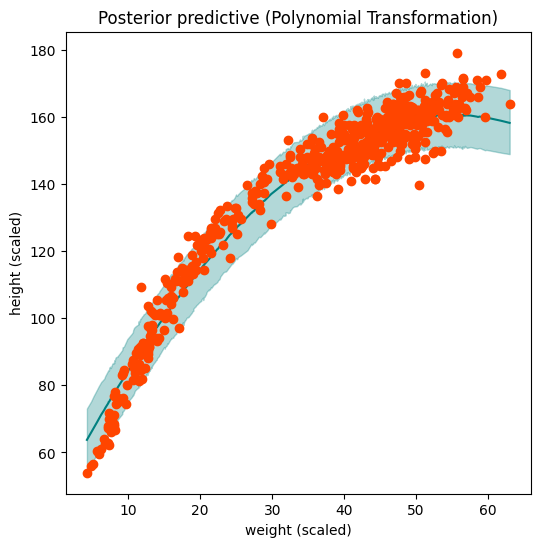

In [ ]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_poly, samples_poly)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']
mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)
ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive (Polynomial Transformation)")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

In [ ]:
# Predict for new data
predictive = Predictive(model_poly, samples_poly)
predictions_poly = predictive(rng_key_, weight=weight_pred)['obs']
mean_pred_poly = jnp.mean(predictions_poly, axis=0)
hpdi_pred_poly = hpdi(predictions_poly, 0.89)
d_poly = {'weight_pred': weight_pred, 'mean_pred': mean_pred_poly, 'lower': hpdi_pred_poly[0,], 'upper': hpdi_pred_poly[1,]}
df_res_poly = pd.DataFrame(data=d_poly)
df_res_poly.head()

weight_pred   mean_pred       lower       upper
0           45  156.784668  147.500412  166.148956
1           40  152.225433  142.878937  161.372223
2           65  156.736359  147.213562  165.922791
3           31  138.972885  129.944962  148.415604
4           53  160.276581  150.958862  169.391388

## Model comparison

#Task 19

Assume that the ‘true’ model is $M_0$ and the two candidate models
for these models are $M_1$ and $M_2$

$M_0$ : y ∼ N (3, 2)

$M_1$ : y ∼ N (3.5, 2.5)

$M_2$ : y ∼ Cauchy(3, 2)

For these models,

-Plot the three densities

-Compute divergences $KLD(M_0 ∥ M_1)$ , $KLD(M0 ∥ M2)$

-Which model is better: $M_1$ or $M_2$




KL Divergence (M_0 vs. M_1): 0.057471942
KL Divergence (M_0 vs. M_2): 0.25651652
Model M_1 is closer to M_0


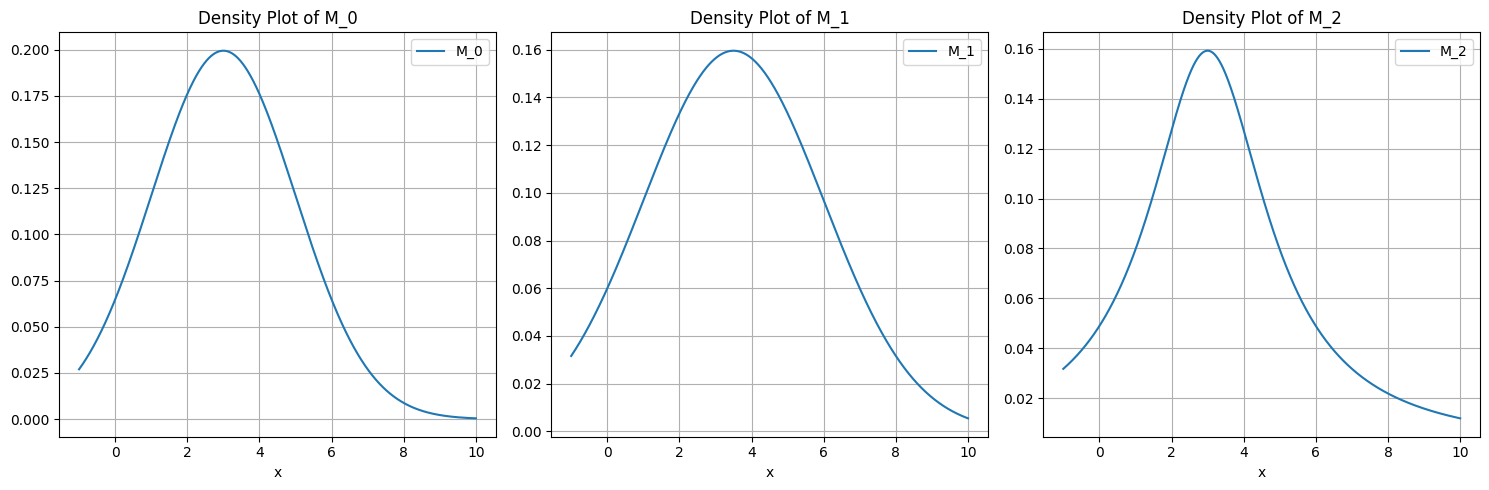

In [ ]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

M_0 = dist.Normal(3, 2)
M_1 = dist.Normal(3.5, 2.5)
M_2 = dist.Cauchy(3, 2)

# Compute Kullback-Leibler Divergence
rng = random.PRNGKey(0)
def kl_divergence(p, q, n=10_000):
    xs = p.sample(rng, sample_shape=(n,))
    p_log_probs = p.log_prob(xs)
    q_log_probs = q.log_prob(xs)

    return -(q_log_probs - p_log_probs).mean()

# KL divergences
kl_M0_M1 = kl_divergence(M_0, M_1)
kl_M0_M2 = kl_divergence(M_0, M_2)

print("KL Divergence (M_0 vs. M_1):", kl_M0_M1)
print("KL Divergence (M_0 vs. M_2):", kl_M0_M2)

if kl_M0_M1 < kl_M0_M2:
  print("Model M_1 is closer to M_0")
else:
  print("Model M_2 is closer to M_0")

xs = jnp.linspace(-1, 10, 1000)
# Plot densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(xs, jnp.exp(M_0.log_prob(xs)), label='M_0')
ax[0].set_xlabel('x')
ax[0].legend()
ax[0].set_title('Density Plot of M_0')
ax[0].grid(True)

ax[1].plot(xs, jnp.exp(M_1.log_prob(xs)), label='M_1')
ax[1].set_xlabel('x')
ax[1].legend()
ax[1].set_title('Density Plot of M_1')
ax[1].grid(True)

ax[2].plot(xs, jnp.exp(M_2.log_prob(xs)), label='M_2')
ax[2].set_xlabel('x')
ax[2].legend()
ax[2].set_title('Density Plot of M_2')
ax[2].grid(True)

plt.tight_layout()
plt.show()


#Task 20
Download the kidiq dataset (Gelman & Hill, 2007), which is a data from a survey
of adult American women and their respective children. Dated from 2007, it has 434
observations and 4 variables:

kid_score : child’s IQ

mom_hs : binary/dummy (0 or 1) if the child’s mother has a high school diploma

mom_iq : mother’s IQ

mom_age : mother’s age

with

import pandas as pd

!wget -O kidiq.csv https://github.com/TuringLang/TuringGLM.jl/raw/main/data/kidiq.csv

df = pd.read_csv('kidiq.csv')

Construct a model predicting kid_score :

$kidscore_i ∼ N (μ_i, σ^2),$

Build separate models for the following variations of :

$μ_i = β_0 + β_1 mom\_iq_{i}$

$μ_i = β_0 + β_1 mom\_iq_i + β_2 mom\_hs_i$

$μ_i = β_0 + β_1 mom\_iq_i + β_2 mom\_hs_i + β_3 mom\_iq_i × mom\_hs_i $

$μ_i = β_0 + β_1 mom\_iq_i + β_2 mom\_hs_i + β_3 mom\_iq_i × mom\_hs_i + β_4 mom\_age_i$

Show Bayesian workflow for each of the models.

Compare the models with each other. Which model would you chose as final
and why?

Construct a model predicting kid_score :

In [ ]:
import pandas as pd

!wget -O kidiq.csv https://github.com/TuringLang/TuringGLM.jl/raw/main/data/kidiq.csv

df = pd.read_csv('kidiq.csv')

--2024-04-06 20:59:17--  https://github.com/TuringLang/TuringGLM.jl/raw/main/data/kidiq.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TuringLang/TuringGLM.jl/main/data/kidiq.csv [following]
--2024-04-06 20:59:17--  https://raw.githubusercontent.com/TuringLang/TuringGLM.jl/main/data/kidiq.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10968 (11K) [text/plain]
Saving to: ‘kidiq.csv’

kidiq.csv           100%[===================>]  10.71K  --.-KB/s    in 0.001s  

2024-04-06 20:59:18 (11.1 MB/s) - ‘kidiq.csv’ saved [10968/10968]



In [ ]:
print(df)

     kid_score  mom_hs      mom_iq  mom_age
0           65       1  121.117529       27
1           98       1   89.361882       25
2           85       1  115.443165       27
3           83       1   99.449639       25
4          115       1   92.745710       27
..         ...     ...         ...      ...
429         94       0   84.877412       21
430         76       1   92.990392       23
431         50       0   94.859708       24
432         88       1   96.856624       21
433         70       1   91.253336       25

[434 rows x 4 columns]


In [ ]:
#Model 1:
import numpyro
import numpyro.distributions as dist


def model_1(mom_iq=None, kid_score=None):
    # Define priors
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # Define mean
    mu_1 = b0 + b1 * mom_iq

    # Likelihood
    numpyro.sample('obs', dist.Normal(mu_1, sigma), obs = kid_score)

#Model 2:
def model_2(mom_iq=None, mom_hs=None, kid_score=None):
    # Define priors
    b0 = numpyro.sample('b0', dist.Normal(100, 100))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # Define mean
    mu_2 = b0 + b1 * mom_iq + b2 * mom_hs

    # Likelihood
    numpyro.sample('obs', dist.Normal(mu_2, sigma), obs=kid_score)

#Model 3:
def model_3(mom_iq=None, mom_hs=None, kid_score=None):
    # Define priors
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    b3 = numpyro.sample('b3', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # Define mean
    mu_3 = b0 + b1 * mom_iq + b2 * mom_hs + b3 * mom_iq * mom_hs

    # Likelihood
    numpyro.sample('obs', dist.Normal(mu_3, sigma), obs=kid_score)

#Model 4:
def model_4(mom_iq=None, mom_hs=None, mom_age=None, kid_score=None):
    # Define priors
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    b3 = numpyro.sample('b3', dist.Normal(0, 1))
    b4 = numpyro.sample('b4', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # Define mean
    mu_4 = b0 + b1 * mom_iq + b2 * mom_hs + b3 * mom_iq * mom_hs + b4 * mom_age

    # Likelihood
    numpyro.sample('obs', dist.Normal(mu_4, sigma), obs=kid_score)



In [ ]:
# Extracting variables from the dataset
mom_hs = df['mom_hs'].values
mom_iq = df['mom_iq'].values
mom_age = df['mom_age'].values
kid_score = df['kid_score'].values

In [ ]:
#Data to make predictions
mom_iq_pred = jnp.array([135, 80, 115, 100, 95])
#Data to make predictions
mom_hs_pred = jnp.array([0, 1])
#Data to make predictions
mom_age_pred = jnp.array([17.5, 20, 22.5, 27, 27.5])

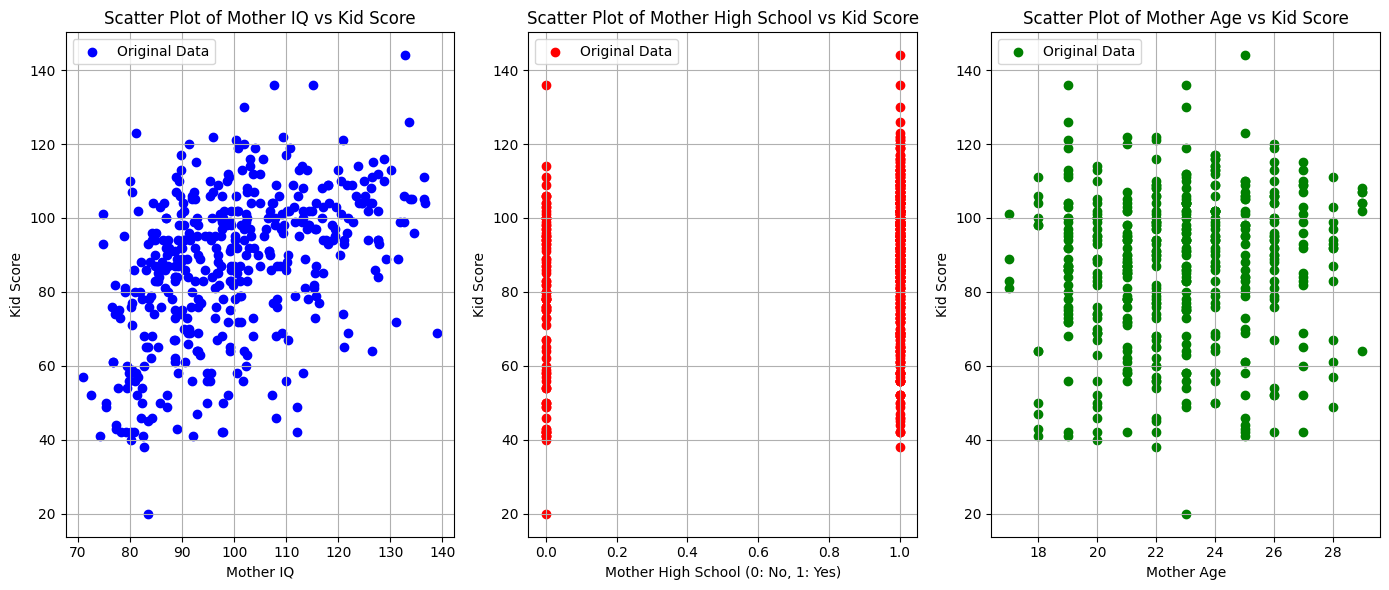

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# Scatter plot of Mother IQ vs Kid Score
axs[0].scatter(df['mom_iq'], df['kid_score'], color='blue', label='Original Data')
axs[0].set_xlabel('Mother IQ')
axs[0].set_ylabel('Kid Score')
axs[0].set_title('Scatter Plot of Mother IQ vs Kid Score')
axs[0].legend()
axs[0].grid(True)

# Scatter plot of Mother High School vs Kid Score
axs[1].scatter(df['mom_hs'], df['kid_score'], color='red', label='Original Data')
axs[1].set_xlabel('Mother High School (0: No, 1: Yes)')
axs[1].set_ylabel('Kid Score')
axs[1].set_title('Scatter Plot of Mother High School vs Kid Score')
axs[1].legend()
axs[1].grid(True)

# Scatter plot of Mother Age vs Kid Score
axs[2].scatter(df['mom_age'], df['kid_score'], color='green', label='Original Data')
axs[2].set_xlabel('Mother Age')
axs[2].set_ylabel('Kid Score')
axs[2].set_title('Scatter Plot of Mother Age vs Kid Score')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Define the random key
rng_key = random.PRNGKey(0)

# Split the random key
rng_key, rng_key_ = random.split(rng_key)

# Prior predictive for Model 1
prior_predictive_1 = Predictive(model_1, num_samples=2000)
prior_predictions_1 = prior_predictive_1(rng_key_, mom_iq)

# Prior predictive for Model 2
prior_predictive_2 = Predictive(model_2, num_samples=2000)
prior_predictions_2 = prior_predictive_2(rng_key_, mom_iq, mom_hs)

# Prior predictive for Model 3
prior_predictive_3 = Predictive(model_3, num_samples=2000)
prior_predictions_3 = prior_predictive_3(rng_key_, mom_iq, mom_hs)

# Prior predictive for Model 4
prior_predictive_4 = Predictive(model_4, num_samples=2000)
prior_predictions_4 = prior_predictive_4(rng_key_, mom_iq, mom_hs, mom_age)

# Print keys of prior predictive samples
print("Keys of prior predictions for Model 1:", prior_predictions_1.keys())
print("Keys of prior predictions for Model 2:", prior_predictions_2.keys())
print("Keys of prior predictions for Model 3:", prior_predictions_3.keys())
print("Keys of prior predictions for Model 4:", prior_predictions_4.keys())


Keys of prior predictions for Model 1: dict_keys(['b0', 'b1', 'obs', 'sigma'])
Keys of prior predictions for Model 2: dict_keys(['b0', 'b1', 'b2', 'obs', 'sigma'])
Keys of prior predictions for Model 3: dict_keys(['b0', 'b1', 'b2', 'b3', 'obs', 'sigma'])
Keys of prior predictions for Model 4: dict_keys(['b0', 'b1', 'b2', 'b3', 'b4', 'obs', 'sigma'])


In [ ]:
# Calculate mean and HPDI for each model

pred_obs_1 = prior_predictions_1['obs']
mean_prior_pred_1 = jnp.mean(pred_obs_1, axis=0)
hpdi_prior_pred_1 = hpdi(pred_obs_1, 0.89)

pred_obs_2 = prior_predictions_2['obs']
mean_prior_pred_2 = jnp.mean(pred_obs_2, axis=0)
hpdi_prior_pred_2 = hpdi(pred_obs_2, 0.89)

pred_obs_3 = prior_predictions_3['obs']
mean_prior_pred_3 = jnp.mean(pred_obs_3, axis=0)
hpdi_prior_pred_3 = hpdi(pred_obs_3, 0.89)

pred_obs_4 = prior_predictions_4['obs']
mean_prior_pred_4 = jnp.mean(pred_obs_4, axis=0)
hpdi_prior_pred_4 = hpdi(pred_obs_4, 0.89)

In [ ]:
def plot_regression(x, y_mean, y_hpdi, kid_score, ttl='Predictions with 89% CI'):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    x_sorted = x[idx]
    mean_sorted = y_mean[idx]
    hpdi_sorted = y_hpdi[:, idx]
    kid_score_sorted = kid_score[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    ax.plot(x_sorted, mean_sorted, color='teal', label='Mean Prediction')
    ax.plot(x_sorted, kid_score_sorted, 'o', color='orangered', label='Actual Kid Score')
    ax.fill_between(x_sorted, hpdi_sorted[0], hpdi_sorted[1], alpha=0.3, interpolate=True, color='teal', label='89% CI')
    ax.set_xlabel('Mother IQ')
    ax.set_ylabel('Kid Score')
    ax.set_title(ttl)
    ax.legend()
    ax.grid(True)
    return ax

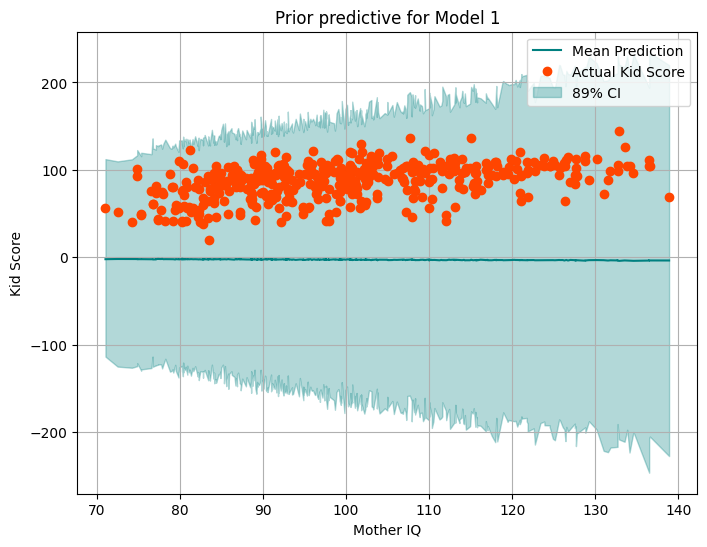

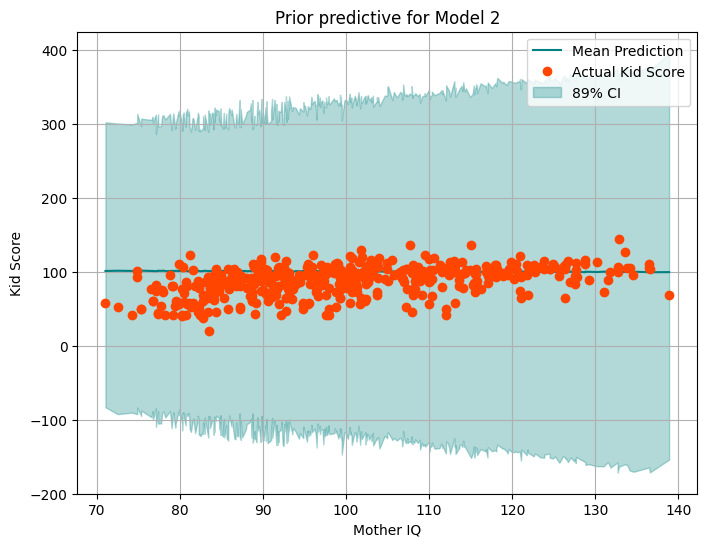

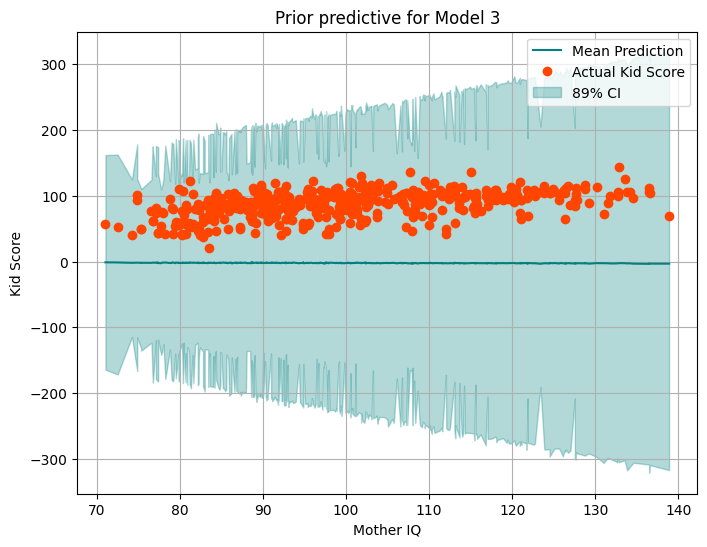

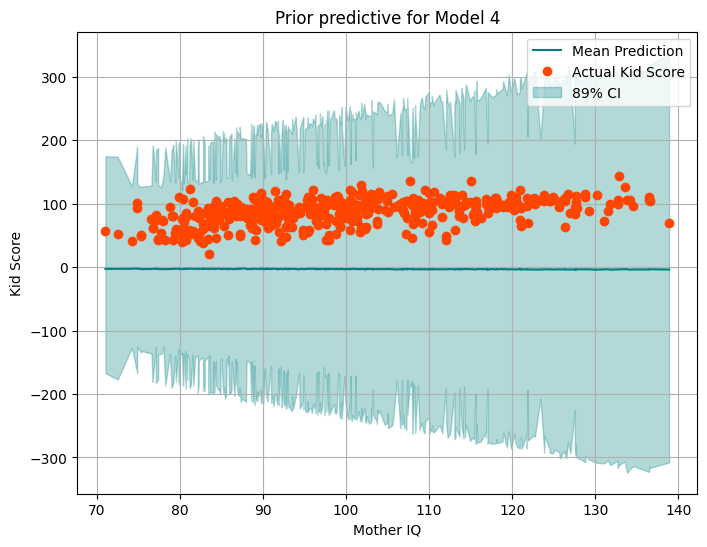

In [ ]:
ax = plot_regression(mom_iq, mean_prior_pred_1, hpdi_prior_pred_1, kid_score, ttl="Prior predictive for Model 1")
ax = plot_regression(mom_iq, mean_prior_pred_2, hpdi_prior_pred_2, kid_score, ttl="Prior predictive for Model 2")
ax = plot_regression(mom_iq, mean_prior_pred_3, hpdi_prior_pred_3, kid_score, ttl="Prior predictive for Model 3")
ax = plot_regression(mom_iq, mean_prior_pred_4, hpdi_prior_pred_4, kid_score, ttl="Prior predictive for Model 4")


In [ ]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel_1 = NUTS(model_1)
mcmc_1 = MCMC(nuts_kernel_1, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)
mcmc_1.run(rng_key_ , mom_iq, kid_score)
mcmc_1.print_summary()
samples_1 = mcmc_1.get_samples()

nuts_kernel_2 = NUTS(model_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)
mcmc_2.run(rng_key_ , mom_iq, mom_hs, kid_score)
mcmc_2.print_summary()
samples_2 = mcmc_2.get_samples()

nuts_kernel_3 = NUTS(model_3)
mcmc_3 = MCMC(nuts_kernel_3, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)
mcmc_3.run(rng_key_ , mom_iq, mom_hs, kid_score)
mcmc_3.print_summary()
samples_3 = mcmc_3.get_samples()

nuts_kernel_4 = NUTS(model_4)
mcmc_4 = MCMC(nuts_kernel_4, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)
mcmc_4.run(rng_key_ , mom_iq, mom_hs, mom_age, kid_score)
mcmc_4.print_summary()
samples_4 = mcmc_4.get_samples()

<ipython-input-28-8fa0f0809d0b>:7: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_1 = MCMC(nuts_kernel_1, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0      0.72      0.97      0.74     -0.79      2.38   2092.81      1.00
        b1      0.86      0.01      0.86      0.83      0.88   2162.07      1.00
     sigma     18.61      0.62     18.59     17.63     19.66   2875.89      1.00

Number of divergences: 0


<ipython-input-28-8fa0f0809d0b>:13: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_2 = MCMC(nuts_kernel_2, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     26.44      5.80     26.61     17.46     36.35   1590.99      1.00
        b1      0.60      0.06      0.59      0.51      0.69   1590.69      1.00
        b2      1.00      0.91      0.98     -0.57      2.46   2938.56      1.00
     sigma     18.19      0.63     18.17     17.12     19.15   2254.85      1.00

Number of divergences: 0


<ipython-input-28-8fa0f0809d0b>:19: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_3 = MCMC(nuts_kernel_3, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0      0.73      1.02      0.73     -0.89      2.48   3091.68      1.00
        b1      0.84      0.02      0.84      0.80      0.88   2581.19      1.00
        b2      0.78      0.96      0.78     -0.86      2.26   3207.23      1.00
        b3      0.01      0.02      0.01     -0.02      0.06   2708.93      1.00
     sigma     18.58      0.62     18.56     17.57     19.60   3045.33      1.00

Number of divergences: 0


<ipython-input-28-8fa0f0809d0b>:25: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_4 = MCMC(nuts_kernel_4, num_warmup=500, num_samples=2000, num_chains=2, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0      0.25      1.00      0.26     -1.39      1.85   3499.14      1.00
        b1      0.65      0.05      0.65      0.57      0.74   2252.45      1.00
        b2      0.42      0.99      0.43     -1.30      1.97   3592.50      1.00
        b3      0.02      0.02      0.02     -0.01      0.06   3214.13      1.00
        b4      0.84      0.21      0.85      0.51      1.18   2403.38      1.00
     sigma     18.27      0.63     18.24     17.27     19.31   4436.21      1.00

Number of divergences: 0


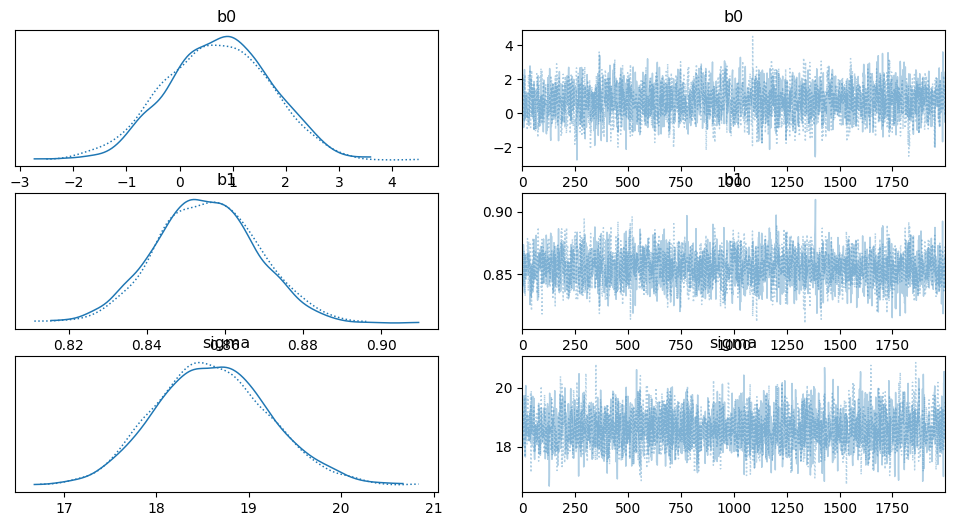

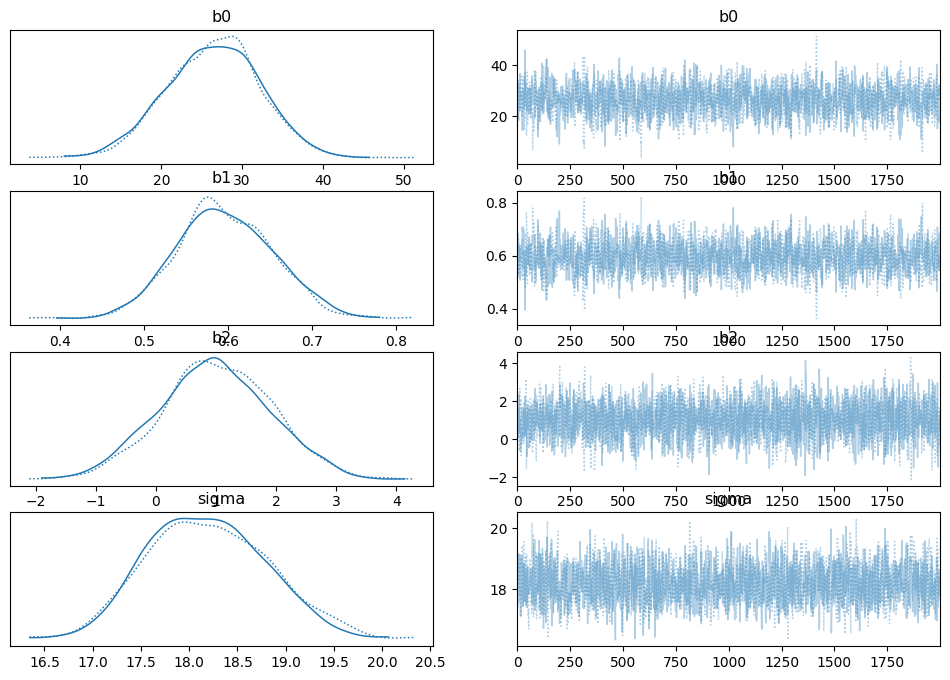

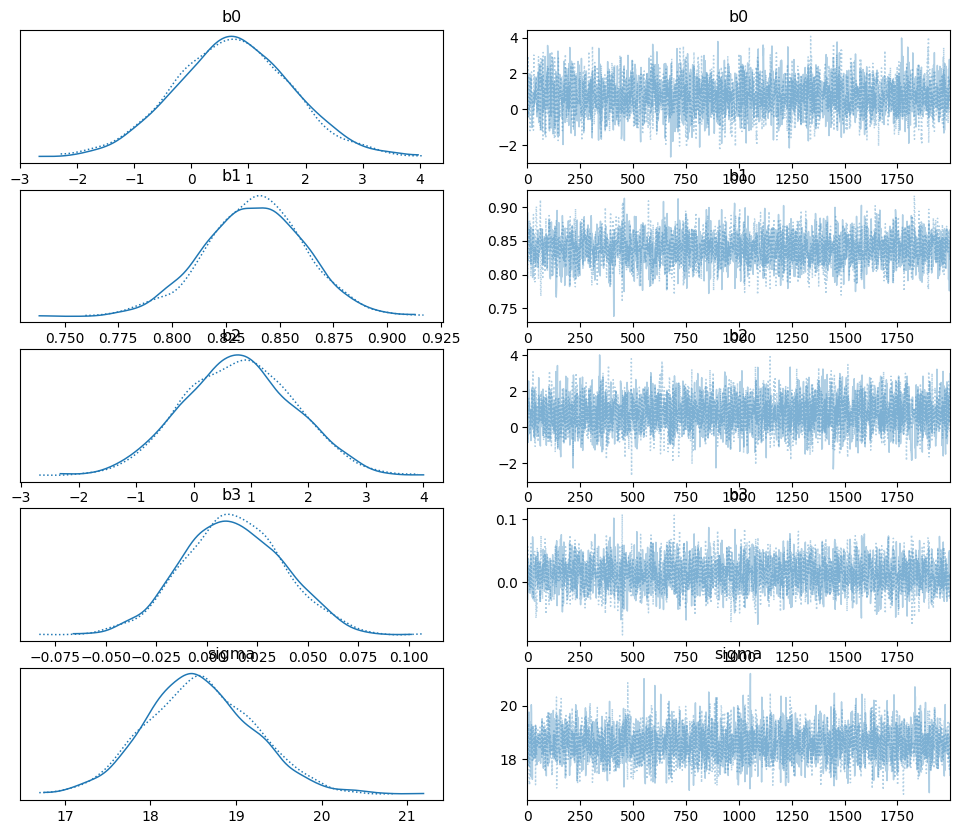

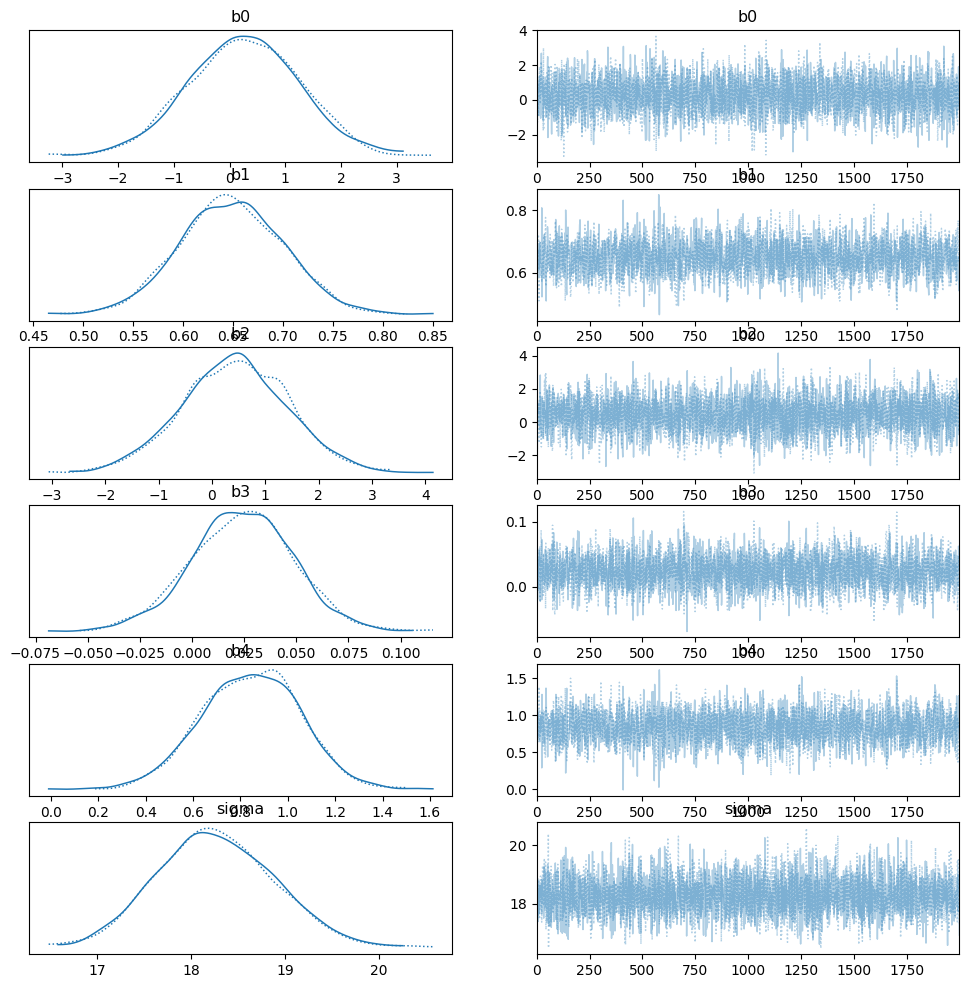

In [ ]:
# plot posterior distribution and traceplots
data_1 = az.from_numpyro(mcmc_1)
az.plot_trace(data_1, compact=True);

data_2 = az.from_numpyro(mcmc_2)
az.plot_trace(data_2, compact=True);

data_3 = az.from_numpyro(mcmc_3)
az.plot_trace(data_3, compact=True);

data_4 = az.from_numpyro(mcmc_4)
az.plot_trace(data_4, compact=True);

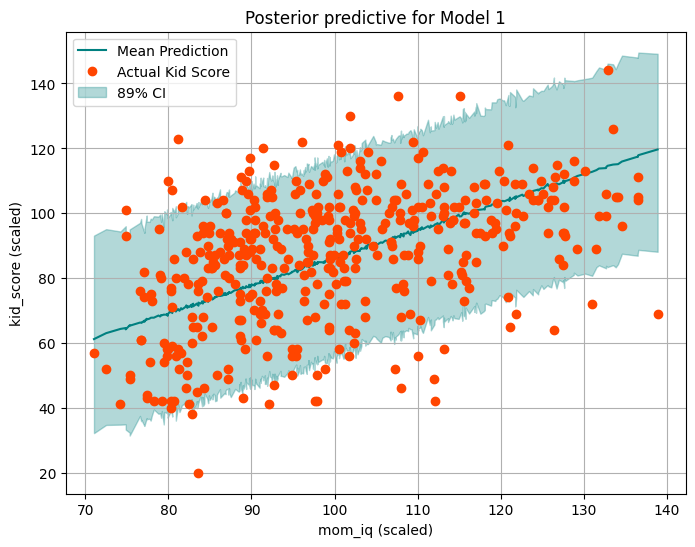

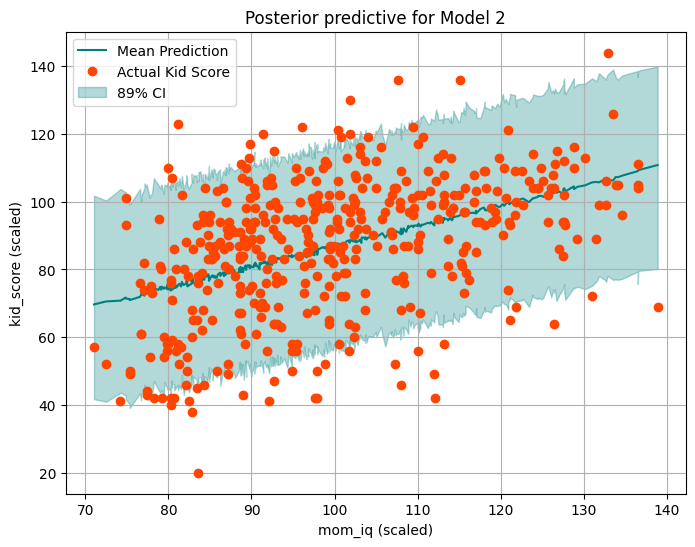

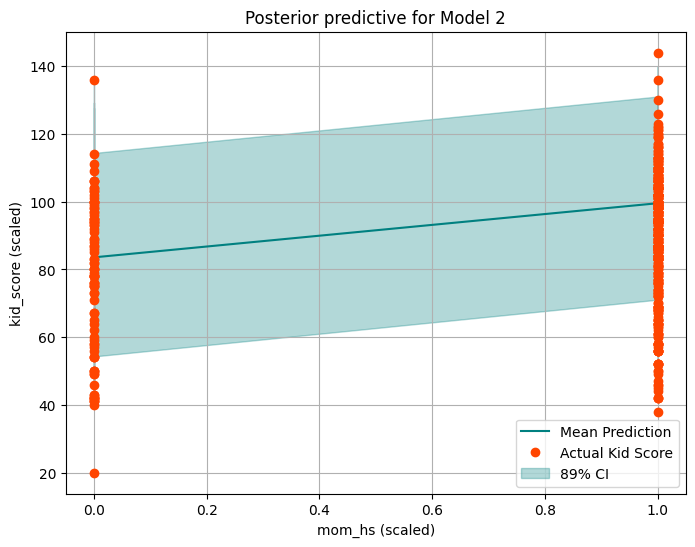

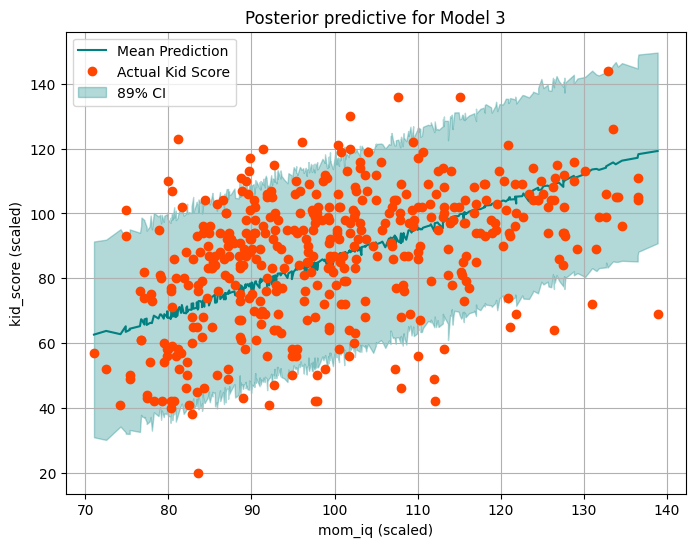

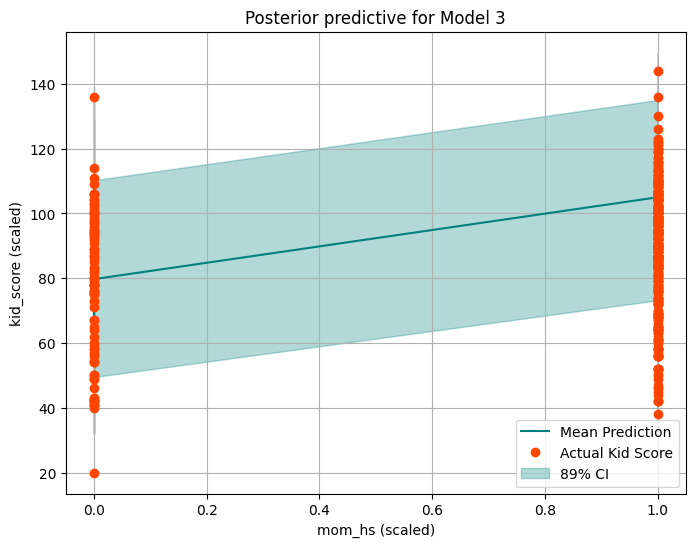

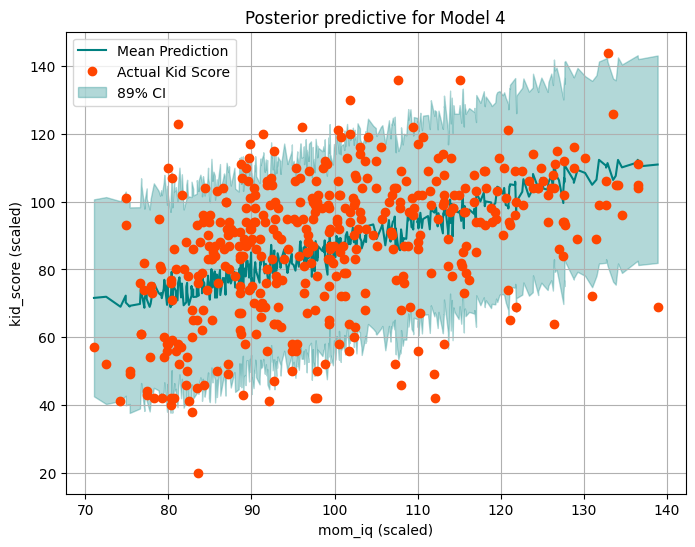

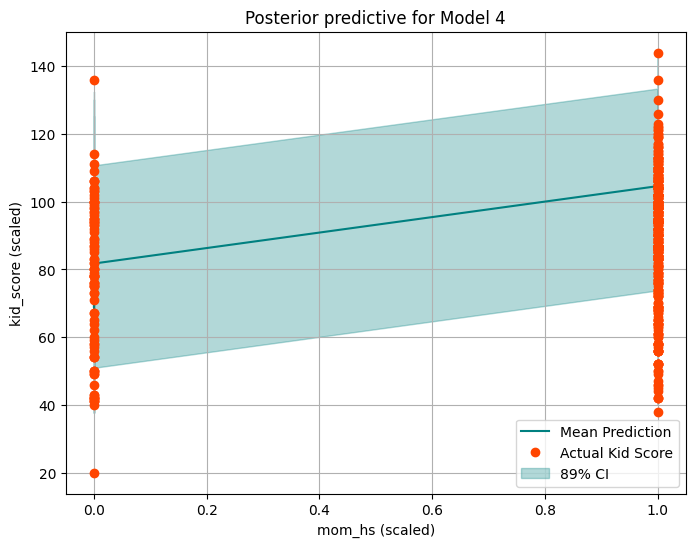

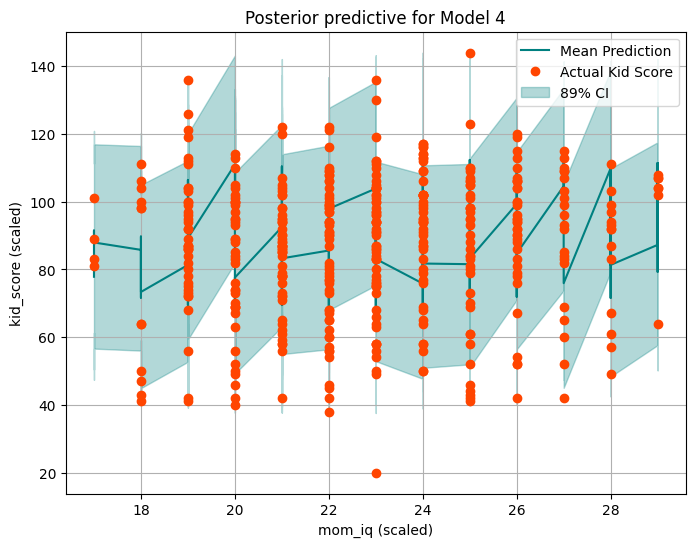

In [ ]:
# Posterior predictive

# Posterior predictive for Model 1
rng_key, rng_key_ = random.split(rng_key)
predictive_1 = Predictive(model_1, samples_1)
posterior_predictions_1 = predictive_1(rng_key_, mom_iq=mom_iq)
post_obs_1 = posterior_predictions_1['obs']

mean_post_pred_1 = jnp.mean(post_obs_1, axis=0)
hpdi_post_pred_1 = hpdi(post_obs_1, 0.9)

ax = plot_regression(mom_iq, mean_post_pred_1, hpdi_post_pred_1, kid_score, ttl="Posterior predictive for Model 1")
ax.set(xlabel='mom_iq (scaled)', ylabel='kid_score (scaled)');


# Posterior predictive for Model 2
rng_key, rng_key_ = random.split(rng_key)
predictive_2 = Predictive(model_2, samples_2)
posterior_predictions_2 = predictive_2(rng_key_, mom_iq=mom_iq, mom_hs=mom_hs)
post_obs_2 = posterior_predictions_2['obs']

mean_post_pred_2 = jnp.mean(post_obs_2, axis=0)
hpdi_post_pred_2 = hpdi(post_obs_2, 0.9)

ax = plot_regression(mom_iq, mean_post_pred_2, hpdi_post_pred_2, kid_score, ttl="Posterior predictive for Model 2")
ax.set(xlabel='mom_iq (scaled)', ylabel='kid_score (scaled)');
ax = plot_regression(mom_hs, mean_post_pred_2, hpdi_post_pred_2, kid_score, ttl="Posterior predictive for Model 2")
ax.set(xlabel='mom_hs (scaled)', ylabel='kid_score (scaled)');


# Posterior predictive for Model 3
rng_key, rng_key_ = random.split(rng_key)
predictive_3 = Predictive(model_3, samples_3)
posterior_predictions_3 = predictive_3(rng_key_, mom_iq=mom_iq, mom_hs=mom_hs)
post_obs_3 = posterior_predictions_3['obs']
mean_post_pred_3 = jnp.mean(post_obs_3, axis=0)
hpdi_post_pred_3 = hpdi(post_obs_3, 0.9)

ax = plot_regression(mom_iq, mean_post_pred_3, hpdi_post_pred_3, kid_score, ttl="Posterior predictive for Model 3")
ax.set(xlabel='mom_iq (scaled)', ylabel='kid_score (scaled)');
ax = plot_regression(mom_hs, mean_post_pred_3, hpdi_post_pred_3, kid_score, ttl="Posterior predictive for Model 3")
ax.set(xlabel='mom_hs (scaled)', ylabel='kid_score (scaled)');


# Posterior predictive for Model 4
rng_key, rng_key_ = random.split(rng_key)
predictive_4 = Predictive(model_4, samples_4)
posterior_predictions_4 = predictive_4(rng_key_, mom_iq=mom_iq, mom_hs=mom_hs, mom_age=mom_age)
post_obs_4 = posterior_predictions_4['obs']

mean_post_pred_4 = jnp.mean(post_obs_4, axis=0)
hpdi_post_pred_4 = hpdi(post_obs_4, 0.9)

ax = plot_regression(mom_iq, mean_post_pred_4, hpdi_post_pred_4, kid_score, ttl="Posterior predictive for Model 4")
ax.set(xlabel='mom_iq (scaled)', ylabel='kid_score (scaled)');

ax = plot_regression(mom_hs, mean_post_pred_4, hpdi_post_pred_4, kid_score, ttl="Posterior predictive for Model 4")
ax.set(xlabel='mom_hs (scaled)', ylabel='kid_score (scaled)');

ax = plot_regression(mom_age, mean_post_pred_4, hpdi_post_pred_4, kid_score, ttl="Posterior predictive for Model 4")
ax.set(xlabel='mom_iq (scaled)', ylabel='kid_score (scaled)');

In [ ]:
# predict for new data
predictive_1_new = Predictive(model_1, samples_1)
predictions_1_new = predictive_1_new(rng_key_, mom_iq=mom_iq_pred)['obs']

mean_pred_1_new = jnp.mean(predictions_1_new, axis=0)
hpdi_pred_1_new = hpdi(predictions_1_new, 0.89)

d_1_new = {'mom_iq_pred_1_new': mom_iq_pred, 'mean_pred_1_new': mean_pred_1_new, 'lower': hpdi_pred_1_new[0,], 'upper': hpdi_pred_1_new[1,]}
df_res_1_new = pd.DataFrame(data=d_1_new)
df_res_1_new.head()

mom_iq_pred_1_new  mean_pred_1_new      lower       upper
0                135       116.178925  87.028206  146.213608
1                 80        68.751022  38.568459   96.615440
2                115        98.840340  70.102264  128.769119
3                100        86.728607  57.083176  117.218605
4                 95        81.658554  50.540691  110.828583

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


         rank     elpd_loo     p_loo  elpd_diff        weight         se  \
model_2     0 -1877.657422  3.098717   0.000000  6.869880e-01  14.537928   
model_4     1 -1879.818349  4.069912   2.160927  3.130120e-01  14.489470   
model_1     2 -1886.421883  1.939258   8.764461  5.532816e-16  14.519162   
model_3     3 -1886.426965  2.958800   8.769543  0.000000e+00  14.453828   

              dse  warning scale  
model_2  0.000000    False   log  
model_4  3.423899    False   log  
model_1  4.287061    False   log  
model_3  4.488422    False   log  


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

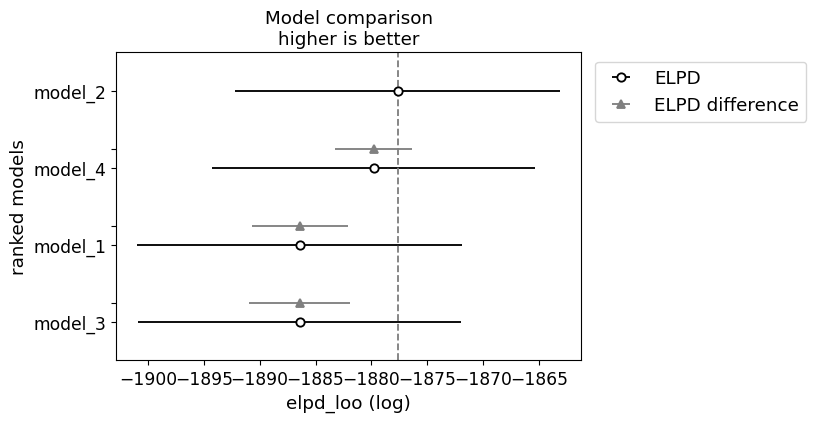

In [ ]:
import arviz as az

# Compare the models
comparison = az.compare({"model_1": data_1, "model_2": data_2, "model_3": data_3, "model_4": data_4},
                         ic="loo")

# Print the comparison table
print(comparison)

# Plot the comparison
az.plot_compare(comparison)

#Task 21

Notice that we are importing one new item from numpyro.infer this time: init_to_median. Research what it is doing. What are the available alternatives?

By initializing the parameters to the median values of the observed data, the MCMC sampler starts its exploration of the parameter space from a point close to the center of the distribution of the observed data.
This initialization strategy aims to facilitate faster convergence of the sampler by starting it in a region of high posterior probability.

Here's a breakdown of **init_to_median:**

**Description:**

init_to_median is a method that sets the initial values of the model parameters to the median of the observed data.

It's particularly useful when the distribution of the data is skewed or contains outliers, as the median is more robust to such deviations than the mean.

How it works:

Given the observed data, init_to_median calculates the median for each parameter.

It then sets the initial values of the parameters to these median values.
This initialization aims to place the MCMC sampler close to the center of the parameter space, potentially improving convergence.


**Advantages:**

*Robustness:*

 The median is robust to outliers and skewed distributions, making it a suitable choice for initialization when the data distribution deviates from normality.

*Efficiency:*

Initializing parameters close to the center of the parameter space may lead to faster convergence of the MCMC sampler.

**Considerations:**

*Applicability:*

init_to_median may not be suitable for all datasets, especially when the median does not adequately represent the center of the parameter space.

*Sensitivity:*

 The effectiveness of init_to_median may vary depending on the specific characteristics of the data and the model.

**Alternative Initialization Strategies:**

Other initialization strategies such as init_to_value, init_to_uniform, init_to_sample, and init_to_prior offer different approaches to setting initial parameter values based on user-defined values, distributions, or prior beliefs.

*Init_to_Value:*

**Description:** Initializes parameters to specific user-defined values.

**Use Cases:** Useful when prior knowledge or domain expertise suggests reasonable starting values for the parameters.

*Init_to_Uniform:*

**Description:** Initializes parameters from a uniform distribution within specified ranges.

**Use Cases:** Appropriate when there is no prior knowledge about the parameter values, and a broad exploration of the parameter space is desired.

*Init_to_Sample:*

**Description:** Initializes parameters from a user-defined distribution.

**Use Cases:** Suitable for cases where the distribution of the parameters is known or can be estimated from prior information.

*Init_to_Prior:*

**Description:** Initializes parameters from the prior distribution.

**Use Cases:** Effective when the prior distribution provides meaningful information about the likely values of the parameters.

So, init_to_median is a valuable initialization strategy in Bayesian inference, particularly when dealing with skewed or outlier-prone data distributions. However, its effectiveness should be evaluated in the context of the specific dataset and model being analyzed.

#Task 22

Draw a diagram showing the hierarchy in the data. What are the “groups” here?

Complete pooling:

Suppose that we took a complete pooling approach to modelling Reaction time (y
) by Days of sleep deprivation (x
). Draw a diagram of complete pooling.

Ignore the subjects and fit the complete pooling model. Visualise the result.

No pooling:

Construct and discuss separate scatterplots of Reaction by Days for each Subject.

Fit the no pooling model to the data.

Partial pooling:

Plot only data for subjects 308 and 335.

For these two subjects, provide a loose sketch of three separate trend lines corresponding to a complete pooled, no pooled, and partial pooled model

Fit a partially poolled model and visualise the results

In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax
from jax import random
import jax.numpy as jnp

rng_key = random.PRNGKey(678)

import pandas as pd

import matplotlib.pyplot as plt

**Complete Pooling**

In [ ]:
# To get the file using wget
!wget -O sleepstudy.csv https://raw.githubusercontent.com/elizavetasemenova/prob-epi/main/data/sleepstudy.csv
df = pd.read_csv('sleepstudy.csv')
# Drop the colum
df = df.drop('Unnamed: 0', axis=1)
df.head()


#df = pd.read_csv('data/sleepstudy.csv')
# Drop the column
#df = df.drop('Unnamed: 0', axis=1)
#df.head()

--2024-04-06 21:11:01--  https://raw.githubusercontent.com/elizavetasemenova/prob-epi/main/data/sleepstudy.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4036 (3.9K) [text/plain]
Saving to: ‘sleepstudy.csv’

sleepstudy.csv      100%[===================>]   3.94K  --.-KB/s    in 0s      

2024-04-06 21:11:02 (47.2 MB/s) - ‘sleepstudy.csv’ saved [4036/4036]



Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308

In [ ]:
data = jnp.array(df['Reaction'].values) # remember to turn data into a jnp array
days = jnp.array(df['Days'].values)
df.head()

Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308

   $
   b0
    |
    |__ b1
    |
    |__ \sigma
$

<ipython-input-37-4129e909e791>:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=2, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0      1.33      1.02      1.34     -0.21      3.02   1670.70      1.00
        b1      6.18      1.00      6.19      4.52      7.83   1816.04      1.00
     sigma    191.06      6.63    190.98    179.93    201.77   1691.12      1.00

Number of divergences: 0


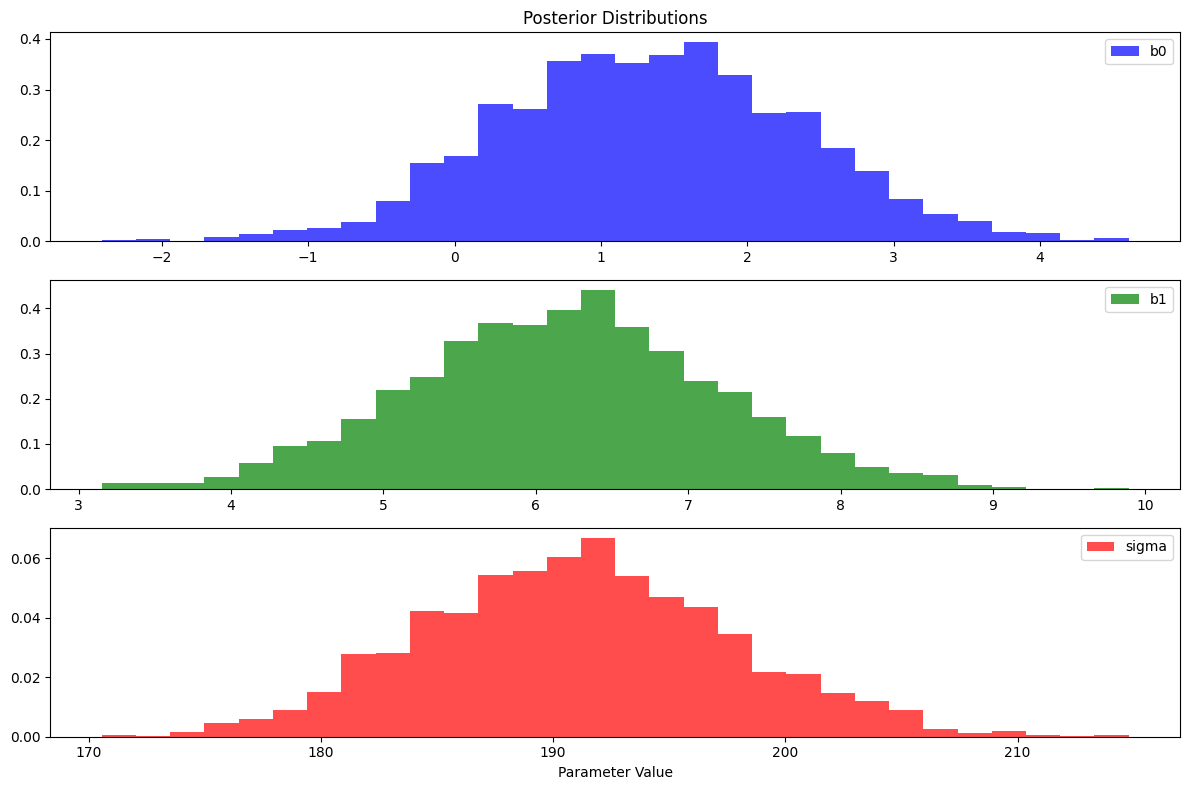

In [ ]:
# Define the complete pooling model
def complete_pooling_model(data, days):
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    mu = b0 + b1 * days
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=data)

# Run inference
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(complete_pooling_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=2, progress_bar=False)
mcmc.run(rng_key, data=df['Reaction'].values, days=df['Days'].values)

# Print summary
mcmc.print_summary()

# Get posterior samples
posterior_samples = mcmc.get_samples()

# Plot posterior distributions
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.hist(posterior_samples['b0'], bins=30, density=True, color='blue', alpha=0.7, label='b0')
plt.legend()
plt.title('Posterior Distributions')
plt.subplot(312)
plt.hist(posterior_samples['b1'], bins=30, density=True, color='green', alpha=0.7, label='b1')
plt.legend()
plt.subplot(313)
plt.hist(posterior_samples['sigma'], bins=30, density=True, color='red', alpha=0.7, label='sigma')
plt.xlabel('Parameter Value')
plt.legend()
plt.tight_layout()
plt.show()


**No Pooling :**

  $ Subject 1
     |
     |__ b0_1
     |
     |__ b1_1
     |
     |__ \sigma_1
  $        
   $  Subject 2
     |
     |__ b0_2
     |
     |__ b1_2
     |
     |__ \sigma _2
  $
      ...

   $Subject n
     |
     |__ b0_n
     |
     |__ b1_n
     |
     |__ \sigma_n
     $


In [ ]:
# Define the no pooling model
def no_pooling_model(data, days):
    for i, subject_data in enumerate(data):
        b0 = numpyro.sample(f'b0_{i}', dist.Normal(0, 1))
        b1 = numpyro.sample(f'b1_{i}', dist.Normal(0, 1))
        mu = b0 + b1 * days[i]
        sigma = numpyro.sample(f'sigma_{i}', dist.Exponential(1))
        numpyro.sample(f'obs_{i}', dist.Normal(mu, sigma), obs=subject_data)

# Run inference
nuts_kernel = NUTS(no_pooling_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500 , num_chains= 2, progress_bar=False)
mcmc.run(rng_key, data=df.groupby('Subject')['Reaction'].apply(jnp.array).values, days=df.groupby('Subject')['Days'].apply(jnp.array).values)

# Print summary
mcmc.print_summary()

<ipython-input-38-9cfc86e48521>:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500 , num_chains= 2, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b0_0      0.34      1.00      0.33     -1.21      2.09   3231.14      1.00
      b0_1      0.41      1.01      0.39     -1.15      2.13   3238.96      1.00
     b0_10      0.33      1.02      0.28     -1.39      1.98   2722.33      1.00
     b0_11      0.32      1.07      0.33     -1.41      2.05   2669.71      1.00
     b0_12      0.36      1.00      0.34     -1.26      2.03   2551.18      1.00
     b0_13      0.33      1.01      0.35     -1.27      2.02   3033.69      1.00
     b0_14      0.32      0.99      0.31     -1.33      1.94   2599.65      1.00
     b0_15      0.35      0.96      0.35     -1.23      2.01   3998.02      1.00
     b0_16      0.34      1.02      0.33     -1.19      2.12   2447.53      1.00
     b0_17      0.32      0.96      0.33     -1.25      1.93   2806.18      1.00
      b0_2      0.40      0.99      0.40     -1.29      1.97   3021.72      1.00
      b0_3      0.35      0

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


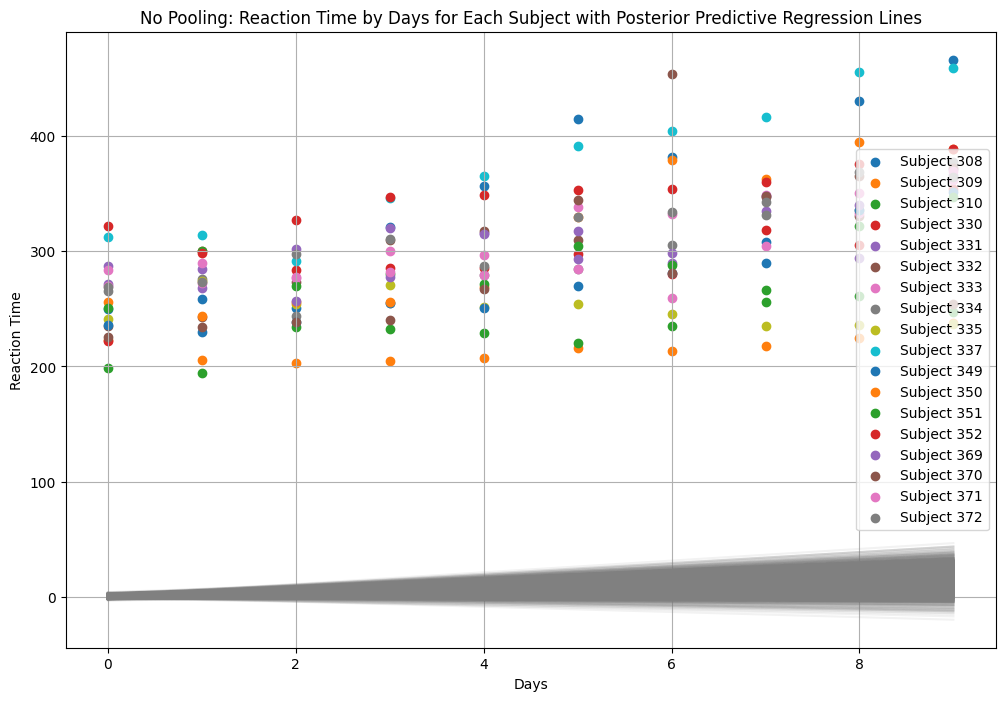

In [ ]:
# Get posterior samples
posterior_samples_no_pooling = mcmc.get_samples()

# Extract unique subject IDs
subjects = df['Subject'].unique()

# Plot scatterplots for each subject
plt.figure(figsize=(12, 8))
for subject in subjects:
    subject_data = df[df['Subject'] == subject]
    plt.scatter(subject_data['Days'], subject_data['Reaction'], label=f'Subject {subject}')

# Plot regression lines based on posterior samples
for i in range(len(subjects)):
    b0_samples = posterior_samples_no_pooling[f'b0_{i}']
    b1_samples = posterior_samples_no_pooling[f'b1_{i}']
    days_range = jnp.linspace(df['Days'].min(), df['Days'].max(), 100)
    for j in range(200):  # Plot a subset of posterior samples to avoid clutter
        mu = b0_samples[j] + b1_samples[j] * days_range
        plt.plot(days_range, mu, color='grey', alpha=0.1)

plt.xlabel('Days')
plt.ylabel('Reaction Time')
plt.title('No Pooling: Reaction Time by Days for Each Subject with Posterior Predictive Regression Lines')
plt.legend()
plt.grid(True)
plt.show()


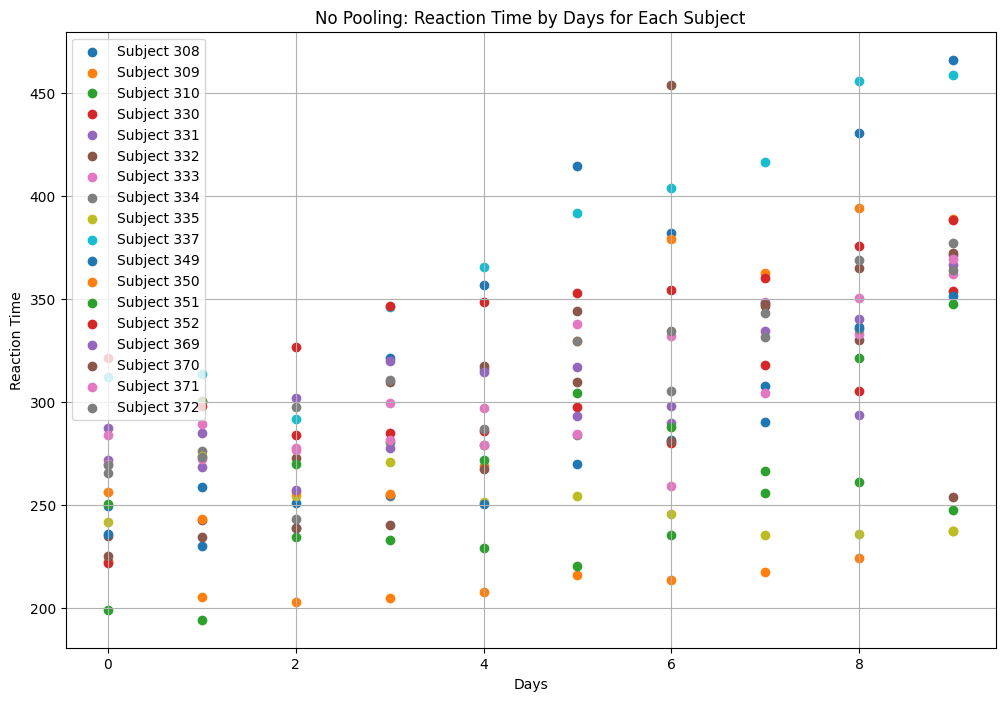

In [ ]:
# Extract unique subject IDs
subjects = df['Subject'].unique()

# Construct and discuss separate scatterplots of Reaction by Days for each Subject
plt.figure(figsize=(12, 8))
for subject in subjects:
    subject_data = df[df['Subject'] == subject]
    plt.scatter(subject_data['Days'], subject_data['Reaction'], label=f'Subject {subject}')

plt.xlabel('Days')
plt.ylabel('Reaction Time')
plt.title('No Pooling: Reaction Time by Days for Each Subject')
plt.legend()
plt.grid(True)
plt.show()

**Partial Pooling**

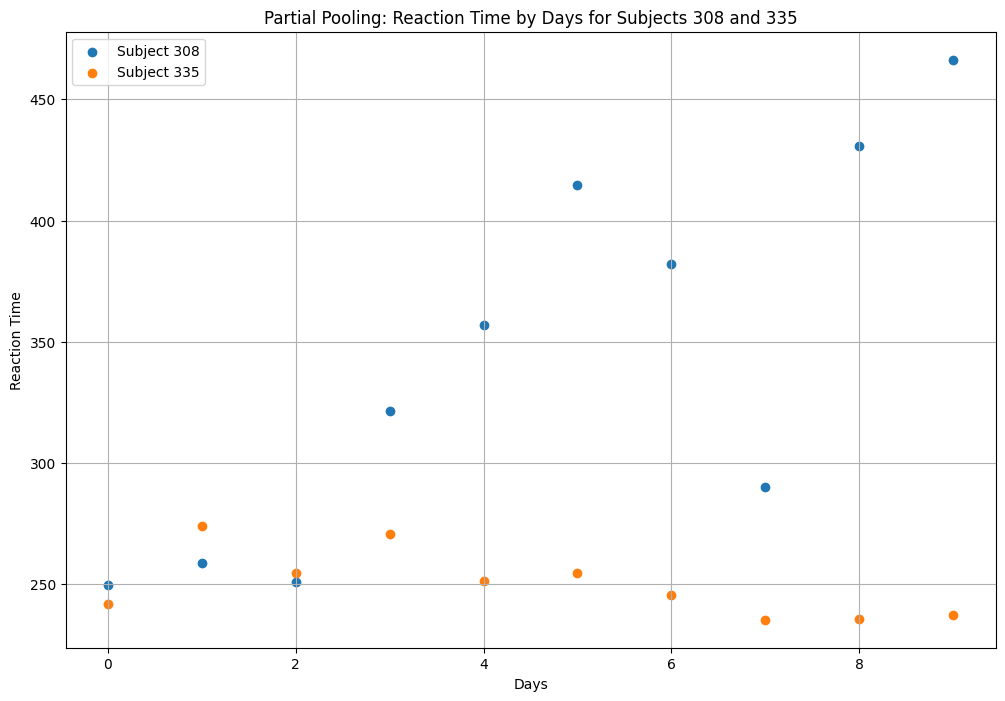

In [ ]:
# Filter data for subjects 308 and 335
subject_308_data = df[df['Subject'] == 308]
subject_335_data = df[df['Subject'] == 335]

# Plot data for subjects 308 and 335
plt.figure(figsize=(12, 8))
plt.scatter(subject_308_data['Days'], subject_308_data['Reaction'], label='Subject 308')
plt.scatter(subject_335_data['Days'], subject_335_data['Reaction'], label='Subject 335')
plt.xlabel('Days')
plt.ylabel('Reaction Time')
plt.title('Partial Pooling: Reaction Time by Days for Subjects 308 and 335')
plt.legend()
plt.grid(True)
plt.show()

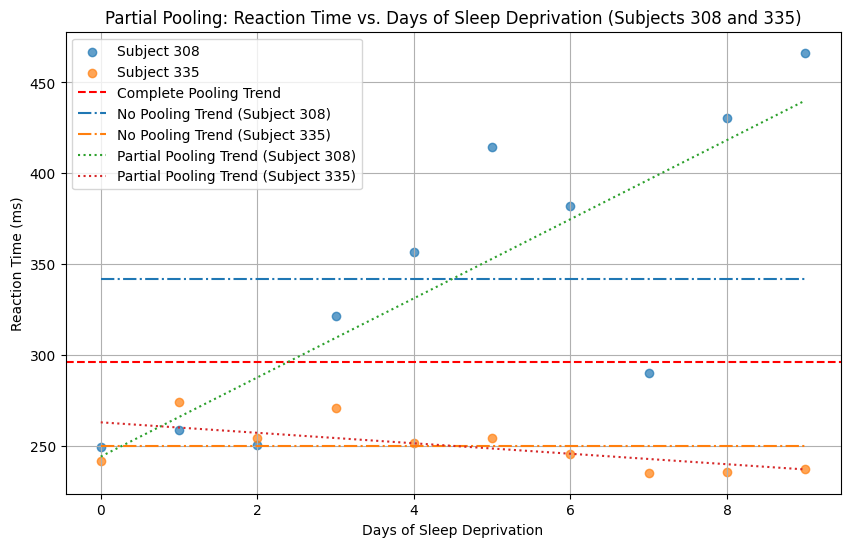

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Filter data for subjects 308 and 335
partial_pooling_data = df[df['Subject'].isin([308, 335])]

# Plot data for subjects 308 and 335
plt.figure(figsize=(10, 6))
for subject in partial_pooling_data['Subject'].unique():
    subject_data = partial_pooling_data[partial_pooling_data['Subject'] == subject]
    plt.scatter(subject_data['Days'], subject_data['Reaction'], label=f'Subject {subject}', alpha=0.7)

# Complete Pooling trend line (based on mean reaction time)
plt.axhline(y=partial_pooling_data['Reaction'].mean(), color='r', linestyle='--', label='Complete Pooling Trend')

# No Pooling trend lines (individual subjects)
for subject in partial_pooling_data['Subject'].unique():
    subject_data = partial_pooling_data[partial_pooling_data['Subject'] == subject]
    plt.plot(subject_data['Days'], [subject_data['Reaction'].mean()] * len(subject_data),
             linestyle='-.', label=f'No Pooling Trend (Subject {subject})')

# Partial Pooling trend line (fitting a simple linear regression model)
# We'll fit a linear regression model separately for each subject
for subject in partial_pooling_data['Subject'].unique():
    subject_data = partial_pooling_data[partial_pooling_data['Subject'] == subject]
    X = subject_data[['Days']]
    y = subject_data['Reaction']
    model = LinearRegression().fit(X, y)
    plt.plot(X, model.predict(X), linestyle=':', label=f'Partial Pooling Trend (Subject {subject})')

plt.xlabel('Days of Sleep Deprivation')
plt.ylabel('Reaction Time (ms)')
plt.title('Partial Pooling: Reaction Time vs. Days of Sleep Deprivation (Subjects 308 and 335)')
plt.legend()
plt.grid(True)
plt.show()


#Task 23

Cushny, Arthur R., and A. Roy Peebles. “The action of optical isomers: II. Hyoscines.” The Journal of Physiology (1905)

The dataset sleep.csv contains results of a small clinical trial.

In this study, ten individuals were administered a sleep aid drug, followed by another sleep aid drug. The study tracked the additional hours of sleep each participant experienced under each drug regimen, relative to their baseline measurement.

The dataset is relatively small, with a low sample size and only one predictor variable (the treatment). Luckily, the design of the experiment has a hierarchical structure.

The data for this task can be loaded as follows:

df = pd.read_csv('data/sleep.csv')

df.head()

Plot the data by showing treatment ID on the x-axis, and the number of extra hours of sleep on the y-axis. Add a separate line for each individual.

Before fitting the model, what do you think the result will be: did drug 1 have an effect? did drug 2 have an effect?

Construct a hierarchical model to analyse this data (you might want to consult this analysis for an example).

What conclusions can you make from the analysis about drug 1 and drug 2?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
# To get the file using wget
!wget -O sleepstudy.csv https://raw.githubusercontent.com/elizavetasemenova/prob-epi/main/data/sleep.csv
#df = pd.read_csv('data/sleep.csv')
df= pd.read_csv('https://raw.githubusercontent.com/elizavetasemenova/prob-epi/main/data/sleep.csv')
df.head()



--2024-04-06 21:02:14--  https://raw.githubusercontent.com/elizavetasemenova/prob-epi/main/data/sleep.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264 [text/plain]
Saving to: ‘sleepstudy.csv’

sleepstudy.csv      100%[===================>]     264  --.-KB/s    in 0s      

2024-04-06 21:02:15 (7.31 MB/s) - ‘sleepstudy.csv’ saved [264/264]



extra  group  ID
0    0.7      1   1
1   -1.6      1   2
2   -0.2      1   3
3   -1.2      1   4
4   -0.1      1   5

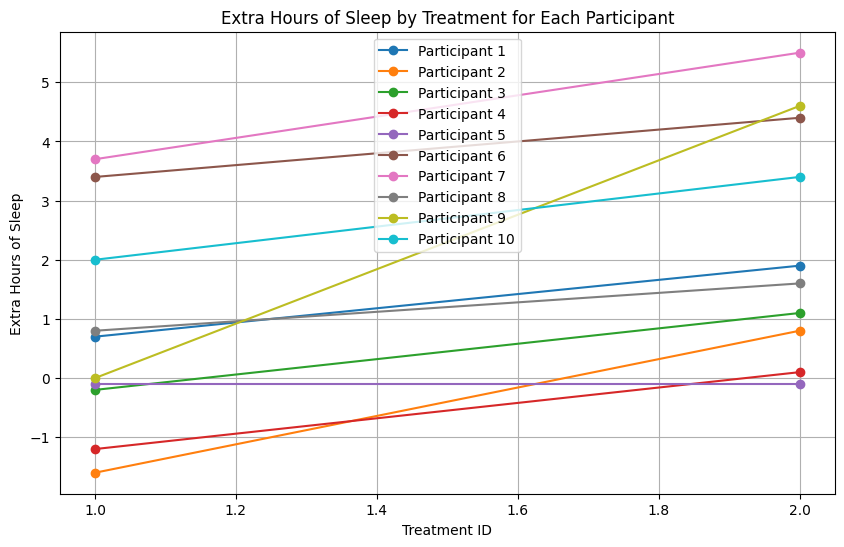

In [ ]:
plt.figure(figsize=(10, 6))
for idx, group in df.groupby('ID'):
    plt.plot(group['group'], group['extra'], marker='o', linestyle='-', label=f'Participant {idx}')

plt.xlabel('Treatment ID')
plt.ylabel('Extra Hours of Sleep')
plt.title('Extra Hours of Sleep by Treatment for Each Participant')
plt.legend()
plt.grid(True)
plt.show()


Since we're dealing with a sleep aid drug study, we would expect that both drugs (Drug 1 and Drug 2) would have an effect on increasing the number of extra hours of sleep compared to the baseline measurement. However, it's also possible that one drug might be more effective than the other, or that there might be variations in response among individuals.

Given the hierarchical structure of the experiment, we might also expect to observe some level of clustering among participants within treatment groups, indicating potential differences in individual responses to the drugs.

Let's consider the following model:

$
y_{ij} = \beta_0 + \beta_1 \text{Treatment}_{ij} + b_i
$

where:

- $ y_{ij} $ is the number of extra hours of sleep for the $ i $th individual under the \( j \)th treatment.

- $\text{Treatment}_{ij}$ is a binary indicator variable for the $ j $th treatment $\text{Treatment}_{ij} = 0$ for Drug 1, $\text{Treatment}_{ij} = 1$ for Drug 2).
- $ \beta_0 $ is the intercept, representing the average effect on sleep hours for Drug 1.
- $ \beta_1 $ is the coefficient for the treatment variable, representing the difference in the average effect on sleep hours between Drug 2 and Drug 1.
- $ b_i $ is the random intercept for the $ i $th individual, capturing individual-specific deviations from the average effect.


Let's construct this hierarchical model to the data and draw conclusions about the effects of Drug 1 and Drug 2.


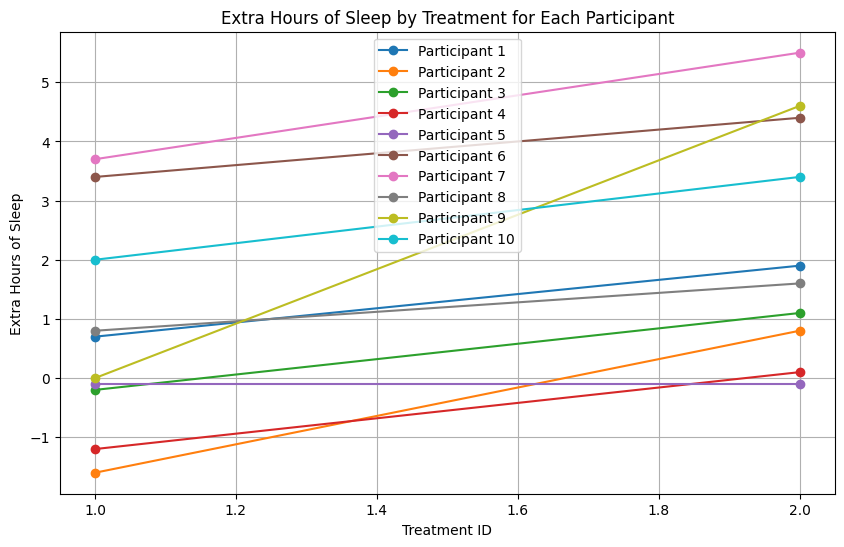

sample: 100%|██████████| 1500/1500 [00:03<00:00, 384.47it/s, 15 steps of size 2.02e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b[0]     -0.24      0.87     -0.25     -1.68      1.15    711.52      1.00
      b[1]     -1.87      0.98     -1.83     -3.62     -0.40    649.89      1.00
      b[2]     -0.89      0.88     -0.89     -2.29      0.55    736.06      1.00
      b[3]     -1.59      0.88     -1.58     -3.10     -0.23    597.22      1.00
      b[4]     -0.79      0.93     -0.78     -2.44      0.57    936.21      1.00
      b[5]      1.62      0.88      1.63      0.12      2.89    832.74      1.00
      b[6]      1.86      0.93      1.86      0.25      3.23    552.24      1.00
      b[7]     -0.19      0.84     -0.16     -1.50      1.17    614.73      1.00
      b[8]     -0.74      0.87     -0.70     -2.26      0.58    944.34      1.00
      b[9]      0.64      0.86      0.63     -0.73      2.13   1035.86      1.00
     b[10]     -0.09      0.93     -0.07     -1.72      1.40    646.78      1.00
     b[11]     -0.84      0

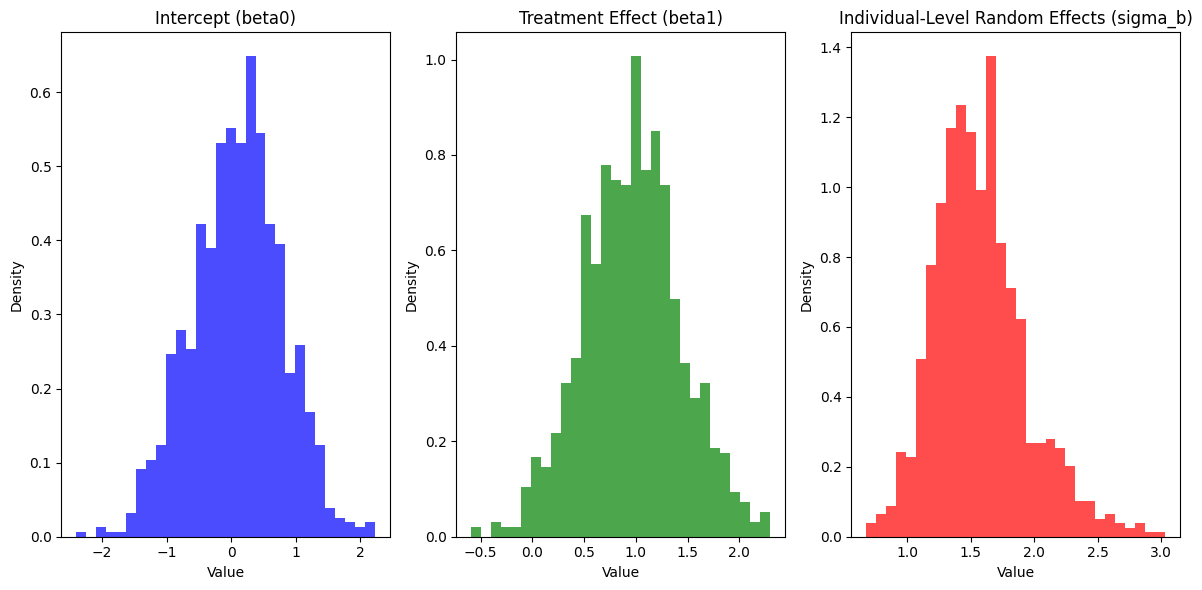

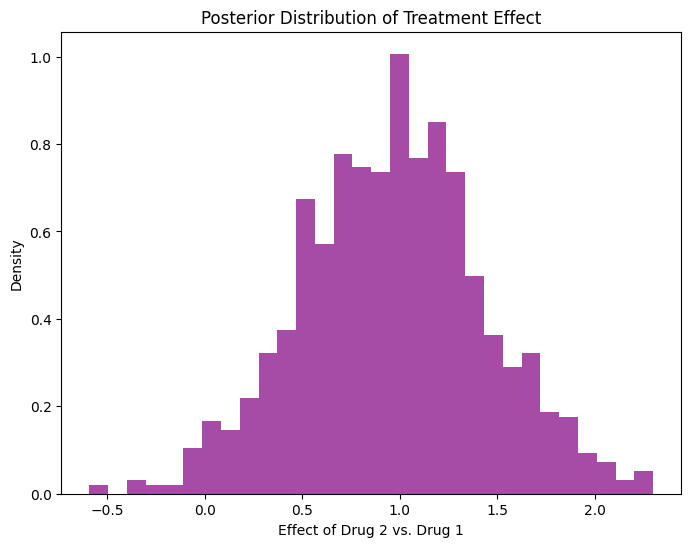

In [ ]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/elizavetasemenova/prob-epi/main/data/sleep.csv')

# Plot the data
plt.figure(figsize=(10, 6))
for idx, group in df.groupby('ID'):
    plt.plot(group['group'], group['extra'], marker='o', linestyle='-', label=f'Participant {idx}')

plt.xlabel('Treatment ID')
plt.ylabel('Extra Hours of Sleep')
plt.title('Extra Hours of Sleep by Treatment for Each Participant')
plt.legend()
plt.grid(True)
plt.show()

# Define the hierarchical model
def hierarchical_model(treatment, extra):
    # Priors
    beta0 = numpyro.sample('beta0', dist.Normal(0, 1))  # Intercept
    beta1 = numpyro.sample('beta1', dist.Normal(0, 1))  # Treatment effect
    sigma_b = numpyro.sample('sigma_b', dist.Exponential(1))  # Individual-level random effects

    # Individual-specific deviations from the average effect
    b = numpyro.sample('b', dist.Normal(0, sigma_b).expand([len(extra)]))

    # Expected value
    mu = beta0 + beta1 * treatment + b

    # Likelihood
    numpyro.sample('obs', dist.Normal(mu, 1), obs=extra)

# Run inference
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
mcmc.run(rng_key, treatment=df['group'].values, extra=df['extra'].values)

# Print summary
mcmc.print_summary()

# Plot posterior distributions
posterior_samples = mcmc.get_samples()
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(posterior_samples['beta0'], bins=30, density=True, color='blue', alpha=0.7)
plt.title('Intercept (beta0)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.subplot(1, 3, 2)
plt.hist(posterior_samples['beta1'], bins=30, density=True, color='green', alpha=0.7)
plt.title('Treatment Effect (beta1)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.subplot(1, 3, 3)
plt.hist(posterior_samples['sigma_b'], bins=30, density=True, color='red', alpha=0.7)
plt.title('Individual-Level Random Effects (sigma_b)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Plot the estimated effects of Drug 1 and Drug 2
plt.figure(figsize=(8, 6))
plt.hist(posterior_samples['beta1'], bins=30, density=True, color='purple', alpha=0.7)
plt.xlabel('Effect of Drug 2 vs. Drug 1')
plt.ylabel('Density')
plt.title('Posterior Distribution of Treatment Effect')
plt.show()
